In [1]:
from __future__ import print_function
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
from MyHelper import *

In [2]:
downloadData(filename,loc)

In [3]:
X,y=getData(filename,loc)

In [4]:
img_size,nchannels = X.shape[1],X.shape[-1]

In [5]:
batch_size = 3

# TensorFlow Helpers

In [20]:
def createWeight(size,Name):
    return tf.Variable(tf.truncated_normal(size, stddev=0.1),name=Name)

def createBias(size,Name):
    return tf.Variable(tf.constant(0.1,shape=size),name=Name)

def lrelu(x, leak=0.2):
    f1 = 0.5 * (1 + leak)
    f2 = 0.5 * (1 - leak)
    return f1 * x + f2 * abs(x)

# Discriminator

In [41]:

g = tf.Graph()
with g.as_default():
    img_input = tf.placeholder(tf.float32,shape=(batch_size,img_size,img_size,nchannels))
    
    W_conv1 = createWeight([5,5,nchannels,64],'d_conv1')
    b_conv1 = createWeight([64],'d_b1')
    
    W_conv2 = createWeight([5,5,64,128],'d_conv2')
    b_conv2 = createWeight([128],'d_b2')

    W_conv3 = createWeight([5,5,128,256],'d_conv3')
    b_conv3 = createWeight([256],'d_b3')

    W_conv4 = createWeight([5,5,256,512],'d_conv4')
    b_conv4 = createWeight([512],'d_b4')
    
    W_logit = createWeight([512*2*2,1],'d_W_logit')
    b_logit = createWeight([1],'d_b_logit')
    
    d_var_list = [W_conv1,b_conv1,W_conv2,b_conv2,W_conv3,b_conv3,W_conv4,b_conv4,W_logit,b_logit]
    
    def D(img_input,var_list):
        W_conv1 = var_list[0]
        b_conv1 = var_list[1]

        W_conv2 = var_list[2]
        b_conv2 = var_list[3]

        W_conv3 = var_list[4]
        b_conv3 = var_list[5]

        W_conv4 = var_list[6]
        b_conv4 = var_list[7]


        conv1 = tf.nn.conv2d(img_input,W_conv1,strides=[1,2,2,1],padding="SAME")
        h1 = lrelu(conv1+b_conv1)

        conv2 = tf.nn.conv2d(h1,W_conv2,strides=[1,2,2,1],padding="SAME")
        h2 = lrelu(conv2+b_conv2)

        conv3 = tf.nn.conv2d(h2,W_conv3,strides=[1,2,2,1],padding="SAME")
        h3 = lrelu(conv3+b_conv3)

        conv4 = tf.nn.conv2d(h3,W_conv4,strides=[1,2,2,1],padding="SAME")
        h4 = lrelu(conv4+b_conv4)

        h4_s = tf.shape(h4)
        h4_flat = tf.reshape(h4,[batch_size,512*(h4_s[1])*(h4_s[2])]) #512*2*2


        logit = tf.matmul(h4_flat,W_logit)+b_logit
        
        return logit
    

# Random Distribution

In [42]:
def Z(n,batch_size):
    """
    Uniform random distribution
    
    Parameters
    -------------
    n : int
        size of the vector to return
    """
    return np.random.uniform(-1, 1, [batch_size,n])

In [43]:
n = 100 #from paper

# Generator

In [63]:

with g.as_default():
    z_input = tf.placeholder(tf.float32,shape=(batch_size,n))

    W_project = createWeight([n,4*4*1024],'g_project')
    b_project = createBias([1,4*4*1024],'g_b_project')

    W_conv1 = createWeight([4,4,512,1024],'g_conv1')
    b_conv1 = createWeight([512],'g_b1')

    W_conv2 = createWeight([7,7,256,512],'g_conv2')
    b_conv2 = createWeight([256],'g_b2')

    W_conv3 = createWeight([14,14,1,256],'g_conv3')
    b_conv3 = createWeight([1],'g_b3')
    
    g_var_list = [W_project,b_project,W_conv1,b_conv1,W_conv2,b_conv2,W_conv3,b_conv3]
    
    def G(z,var_list):
        W_project=var_list[0]
        b_project=var_list[1]
        
        W_conv1 = var_list[2]
        b_conv1 = var_list[3]
        
        W_conv2 = var_list[4]
        b_conv2 = var_list[5]
        
        W_conv3 = var_list[6]
        b_conv3 = var_list[7]

        prjt = tf.matmul(z,W_project)+b_project
        h0 = lrelu(tf.reshape(prjt,shape=(batch_size,4,4,1024)))

        conv1 = tf.nn.conv2d_transpose(h0,W_conv1,output_shape=[batch_size,7,7,512],strides=[1,2,2,1])
        h1 = lrelu(conv1+b_conv1)

        conv2 = tf.nn.conv2d_transpose(h1,W_conv2,output_shape=[batch_size,14,14,256],strides=[1,2,2,1])
        h2 = lrelu(conv2+b_conv2)

        conv3 = tf.nn.conv2d_transpose(h2,W_conv3,output_shape=[batch_size,28,28,1],strides=[1,2,2,1])
        h3 = lrelu(conv3+b_conv3)
        return h3

# Get Variable lists

In [64]:
with g.as_default():
    all_vars = tf.trainable_variables()
    a = all_vars[0]
    print ([v.name for v in all_vars])

[u'd_conv1:0', u'd_b1:0', u'd_conv2:0', u'd_b2:0', u'd_conv3:0', u'd_b3:0', u'd_conv4:0', u'd_b4:0', u'd_W_logit:0', u'd_b_logit:0', u'g_project:0', u'g_b_project:0', u'g_conv1:0', u'g_b1:0', u'g_conv2:0', u'g_b2:0', u'g_conv3:0', u'g_b3:0', u'g_project_1:0', u'g_b_project_1:0', u'g_conv1_1:0', u'g_b1_1:0', u'g_conv2_1:0', u'g_b2_1:0', u'g_conv3_1:0', u'g_b3_1:0']


# Setup Train

In [94]:
with g.as_default():
    z_input = tf.placeholder(tf.float32,shape=(batch_size,n))
    img_input = tf.placeholder(tf.float32,shape=(batch_size,img_size,img_size,nchannels))
    
    G_z = G(z_input,g_var_list)
    D_x = D(img_input,d_var_list)
    D_fake = D(G_z,d_var_list)
    
    
    loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(D_x,tf.ones(shape=[batch_size,1]))+\
            tf.nn.sigmoid_cross_entropy_with_logits(D_fake,tf.zeros(shape=[batch_size,1])))
        
    loss_gen = -tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(D_fake,tf.zeros([batch_size,1])))
    
    opt = tf.train.AdamOptimizer()
    
    d_grads = opt.compute_gradients(loss,var_list=d_var_list)
    d_minimize = opt.apply_gradients(d_grads)
    
    g_grads = opt.compute_gradients(loss_gen,var_list=g_var_list)
    g_max = opt.apply_gradients(g_grads)


# Other

In [95]:
with g.as_default():
    init = tf.initialize_all_variables()

# Session Trains

In [96]:
sess = tf.Session(graph=g)
sess.run(init)

In [ ]:
num_steps = 1000
losses = []
losses_g = []

In [ ]:
num_steps = 200
for i in range(num_steps):
    img_batch = X[i:i+batch_size,:,:,:]
    fd = {z_input:Z(n,3),img_input:img_batch}
    l,_ = sess.run([loss,d_minimize],feed_dict=fd)
    lg,_ = sess.run([loss_gen,g_max],feed_dict=fd)
    losses.append(l),losses_g.append(lg)
G_test = sess.run(G_z,feed_dict=fd)

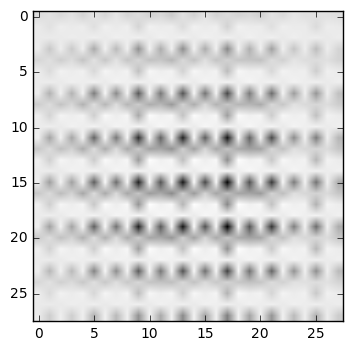

In [116]:
plt.imshow(G_test[2,:,:,0],cmap='Greys')

(0, 1000000.0)

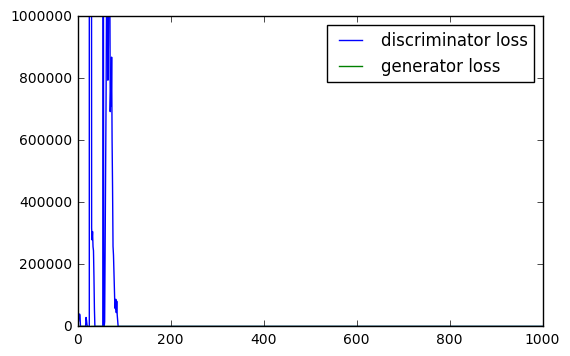

In [111]:
plt.plot(np.arange(len(losses)),losses,np.arange(len(losses)),losses_g)
plt.legend(['discriminator loss','generator loss'])
plt.ylim([0,10e5])

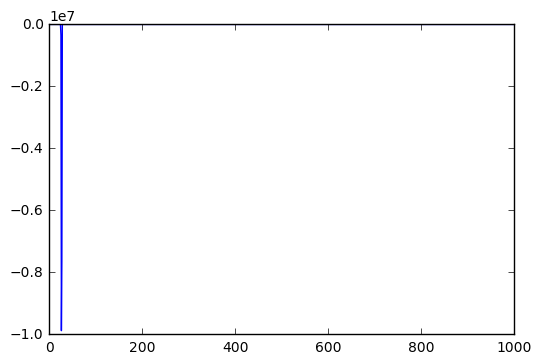

In [112]:
plt.plot(losses_g)

In [113]:
losses

[11800.871,
 15093.384,
 16700.408,
 38769.625,
 40078.812,
 37330.957,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 28970.088,
 20111.455,
 5862.7207,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.1834351e+08,
 1.1243476e+08,
 63720900.0,
 4356128.5,
 317502.41,
 279041.5,
 306033.53,
 257037.31,
 244100.17,
 160536.64,
 56561.984,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1893227.4,
 0.0,
 0.0,
 15236.405,
 254766.02,
 512590.75,
 720918.69,
 1048612.9,
 1120468.4,
 1003781.2,
 794385.19,
 908775.5,
 1192490.1,
 1251400.1,
 1207771.1,
 692906.94,
 758243.56,
 711646.25,
 868733.25,
 599665.0,
 449262.75,
 258394.33,
 230314.05,
 180621.56,
 119111.71,
 62119.027,
 57305.453,
 87632.148,
 44682.676,
 81440.367,
 37682.422,
 18040.713,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0

In [114]:
losses_g

[-0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -344939.41,
 -9877545.0,
 -7641510.5,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -